In [1]:
sys.path.append('../')
from db import get_data, get_gameweek_history
import pandas as pd
import sys
import copy
import seaborn as sns 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Apply the default theme
sns.set_theme()

In [10]:
# Import data
db_data = get_data()
data = db_data[0]
current_players = data[['id']]
current_players = tuple(current_players['id'])

df = pd.DataFrame()

for player in current_players:
    player_gw = get_gameweek_history(player)
    player_gw['id'] = player
    df = df.append(player_gw)

df = df.rename(columns={'total_points': 'event_points', 'value': 'now_cost'})
extra = data[['id', 'team', 'web_name']]
df = pd.merge(df, extra, how='left', on='id')

# Player form + ability:
variables_to_keep = ['web_name', 'team', 'ict_index', 'bps', 'minutes', 'now_cost', 'round', 'event_points'] # should be able to change this in a config file
current_players_df = df[variables_to_keep]

# Fixture difficulty:
# Get upcoming gameweek:
fixture_df = db_data[3]
# Get upcoming gameweek:
current_gw = fixture_df.loc[fixture_df["finished"] == True]
current_gw = current_gw.sort_values(by = ["event"], ascending=False)
current_gw = current_gw.iloc[0][1]
upcoming_gw = current_gw + 1

# 1. Filter out the upcoming gameweek fixtures
fixture_df = fixture_df.loc[fixture_df['event'] == current_gw]

# 2. Separate home and away team FDR and append them into two columns
fixture_a = fixture_df[["team_a", "team_a_difficulty"]]
fixture_a = fixture_a.rename(columns={'team_a': 'team', 'team_a_difficulty': 'fdr'})
fixture_h = fixture_df[["team_h", "team_h_difficulty"]]
fixture_h = fixture_h.rename(columns={'team_h': 'team', 'team_h_difficulty': 'fdr'})
fixture_difficulty = fixture_a.append(fixture_h)

# 3. Merge the FDR to the main dataframe
main_df = pd.merge(current_players_df, fixture_difficulty, how="left", on='team')

main_df = main_df.rename(columns={'web_name': 'name'})

main_df['ict_index'] = main_df['ict_index'].astype('float')

In [3]:
from data import test_fdr

In [13]:
main_df = test_fdr(current_players_df, fixture_df, current_gw)
        
main_df['avg_minutes'] = 0
main_df['ict_index_change'] = 0
main_df['bps_change'] = 0

output_df = pd.DataFrame()
current_round_df = pd.DataFrame()

for name in main_df['name']:
    current_round_df = main_df.loc[main_df["round"] == current_gw]

current_round_df = current_round_df[["name", "event_points"]]
previous_gw_list = list(range(1,current_gw))
# The dataframe for testing the prediction quality (lag all features by removing current gw stats and see what features could possibly explain next weeks points):
for name in main_df['name']:
    input_df = copy.copy(main_df)
    input_df = input_df.loc[input_df['name'] == name]
    input_df = input_df[input_df["round"].isin(previous_gw_list)] # exclude current GW
    input_df['avg_minutes'] = input_df["minutes"].mean()
    if current_gw > 2:
        input_df['ict_index_change'] = input_df["ict_index"].diff(periods=1)
        input_df['bps_change'] = input_df["bps"].diff(periods=1)
    output_df = output_df.append(input_df)

output_df = output_df.drop_duplicates(subset=["name"], keep="last") # keeping only the row with the latest difference stats
output_df = output_df.drop(['event_points'], axis='columns')
output_df = output_df.merge(current_round_df, how="left", on="name")

In [14]:
output_df

,name,team,ict_index,bps,minutes,now_cost,round,fdr,avg_minutes,ict_index_change,bps_change,event_points
0,Leno,1,4.3,20,90,49,3,2,90.0,1.9,3.0,0
1,Rúnarsson,1,0.0,0,0,40,3,2,0.0,0.0,0.0,0
2,Willian,1,0.0,0,0,63,3,2,0.0,0.0,0.0,0
3,Aubameyang,1,0.1,0,58,99,3,2,29.0,-2.4,-5.0,9
4,Cédric,1,0.5,1,90,44,3,2,60.0,-3.3,-14.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
574,Sá,20,1.4,13,90,50,3,2,90.0,-1.8,-1.0,6
575,Cutrone,20,0.0,0,0,50,3,2,0.0,0.0,0.0,0
576,Cundle,20,0.0,0,0,45,3,2,0.0,0.0,0.0,0
577,Campbell,20,0.0,0,0,45,3,2,0.0,0.0,0.0,0


In [13]:
main_df["bps"].describe()

,name,team,ict_index,bps,minutes,now_cost,round,event_points,fdr
0,Leno,1,1.2,11,90,50,1,1,2
1,Leno,1,2.4,17,90,50,2,2,2
2,Leno,1,4.3,20,90,49,3,1,2
3,Leno,1,0.0,0,0,49,4,0,2
4,Rúnarsson,1,0.0,0,0,40,1,0,2
...,...,...,...,...,...,...,...,...,...
2291,Marques,20,0.0,0,0,40,1,0,2
2292,Marques,20,0.0,0,0,40,2,0,2
2293,Marques,20,0.0,0,0,40,3,0,2
2294,Marques,20,0.0,0,0,40,4,0,2


In [29]:
main_df.sort_values(by="bps")

,name,team,ict_index,bps,minutes,now_cost,round,event_points,fdr,avg_minutes,ict_index_change
996,Pérez,9,1.6,-8,39,60,2,-2,3,0,0
1125,Struijk,10,1.1,-6,26,45,4,-3,2,0,0
2112,Antonio,19,4.3,-6,90,80,4,-1,4,0,0
1777,Djenepo,16,4.8,-6,57,55,3,0,5,0,0
1888,Tanganga,17,0.4,-5,57,46,4,-3,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1487,Ronaldo,13,17.8,57,90,125,4,13,4,0,0
695,James,6,19.4,57,90,55,2,18,4,0,0
713,Lukaku,6,11.5,58,90,115,4,13,4,0,0
1416,Fernandes,13,20.1,61,90,120,1,20,4,0,0


In [ ]:
"""
Player form:
    - ict_index (current)
    - bps (current)
    - minutes (average minutes played per match the latest <= 5 matches) - !!!TO DO
    - fdr (for next game)
    - now_cost (current)
"""

In [95]:
main_df['avg_minutes'] = 0
main_df['ict_index_change'] = 0
main_df['bps_change'] = 0

output_df = pd.DataFrame()
current_round_df = pd.DataFrame()


In [96]:
for name in main_df['name']:
     current_round_df = main_df.loc[main_df["round"] == current_gw]

current_round_df = current_round_df[["name", "event_points"]]
previous_gw_list = list(range(1,current_gw))
# The dataframe for testing the prediction quality (lag all features by removing current gw stats and see what features could possibly explain next weeks points):
for name in main_df['name']:
    input_df = copy.copy(main_df)
    input_df = input_df.loc[input_df['name'] == name]
    input_df = input_df[input_df["round"].isin(previous_gw_list)] # exclude current GW
    input_df['avg_minutes'] = input_df["minutes"].mean()
    if current_gw > 2:
         input_df['ict_index_change'] = input_df["ict_index"].diff(periods=1)
         input_df['bps_change'] = input_df["bps"].diff(periods=1)
    output_df = output_df.append(input_df)

output_df = output_df.drop_duplicates(subset=["name"], keep="last")
output_df = output_df.drop(['event_points'], axis='columns')
output_df = output_df.merge(current_round_df, how="left", on="name")
output_df = output_df.sort_values(by="event_points", ascending=False)
output_df # fdr is for next gameweek and not for current gameweek
    

,name,team,ict_index,bps,minutes,now_cost,round,fdr,avg_minutes,ict_index_change,bps_change,event_points
555,Marçal,20,2.1,11,90,45,3,2,90.000000,-2.3,-8.0,13
163,Lukaku,6,7.1,6,90,115,3,4,60.000000,-13.6,-27.0,13
147,Kovacic,6,2.9,4,45,50,3,4,68.666667,0.7,-4.0,13
211,Townsend,8,4.5,11,90,55,3,3,58.000000,3.4,9.0,12
174,Zaha,7,3.5,10,90,69,3,4,90.000000,-0.5,3.0,12
...,...,...,...,...,...,...,...,...,...,...,...,...
238,Justin,9,0.0,0,0,50,3,3,0.000000,0.0,0.0,0
531,Antonio,19,21.2,46,90,78,3,4,89.333333,0.6,-21.0,-1
502,Sierralta,18,1.6,15,90,44,3,2,30.000000,1.6,15.0,-1
263,Struijk,10,2.4,13,90,45,3,2,90.000000,-1.8,-4.0,-3


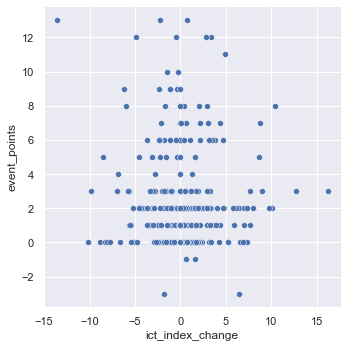

In [79]:
var = 'ict_index_change'
sns.relplot(
    data=output_df,
    x=var, y="event_points"
)

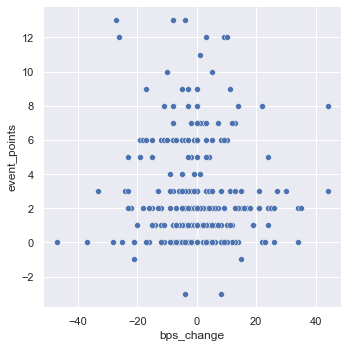

In [80]:
var = 'bps_change'
sns.relplot(
    data=output_df,
    x=var, y="event_points"
)

<AxesSubplot:>

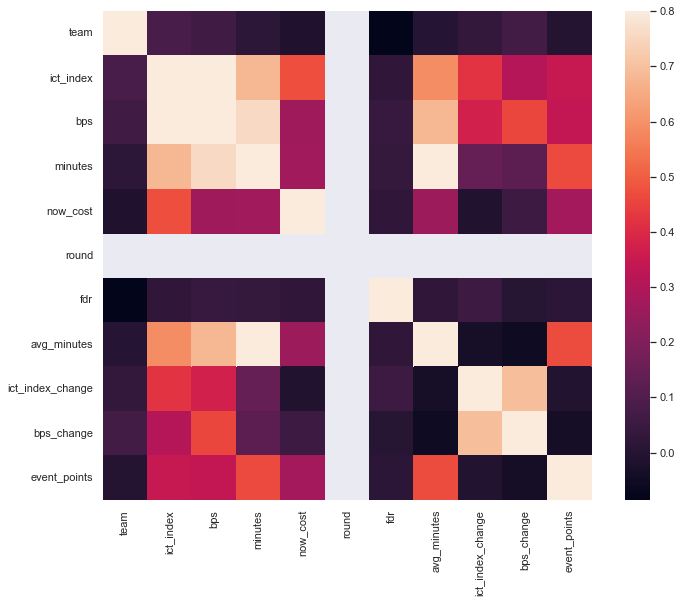

In [81]:
corrmat = output_df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

In [77]:
main_df.loc[main_df['name'] == "Lukaku"]

,name,team,ict_index,bps,minutes,now_cost,round,event_points,fdr,avg_minutes,ict_index_change,bps_change
710,Lukaku,6,0.0,0,0,115,1,0,4,0,0,0
711,Lukaku,6,20.7,33,90,115,2,8,4,0,0,0
712,Lukaku,6,7.1,6,90,115,3,2,4,0,0,0
713,Lukaku,6,11.5,58,90,115,4,13,4,0,0,0


In [49]:
input_df

,name,team,ict_index,bps,minutes,now_cost,round,event_points,fdr,avg_minutes,ict_index_change,bps_change


In [92]:
# The actual dataframe to run for getting preds for next round:


for name in main_df['name']:
    input_df = copy.copy(main_df)
    input_df = input_df.loc[input_df['name'] == name]
    input_df['avg_minutes'] = input_df["minutes"].mean()
    if current_gw > 1:
         input_df['ict_index_change'] = input_df["ict_index"].diff(periods=1)
         input_df['bps_change'] = input_df["bps"].diff(periods=1)
    output_df = output_df.append(input_df)

output_df = output_df.drop_duplicates(subset=["name"], keep="last")
output_df

,name,team,ict_index,bps,minutes,now_cost,round,event_points,fdr,avg_minutes,ict_index_change,bps_change
3,Leno,1,0.0,0,0,49,4,0,2,67.50,-4.3,-20.0
7,Rúnarsson,1,0.0,0,0,40,4,0,2,0.00,0.0,0.0
11,Willian,1,0.0,0,0,63,4,0,2,0.00,0.0,0.0
15,Aubameyang,1,16.1,30,90,99,4,9,2,44.25,16.0,30.0
19,Cédric,1,2.5,5,8,44,4,1,2,47.00,2.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2282,Cutrone,20,0.0,0,0,50,4,0,2,0.00,0.0,0.0
2286,Cundle,20,0.0,0,0,45,4,0,2,0.00,0.0,0.0
2290,Campbell,20,0.0,0,0,45,4,0,2,0.00,0.0,0.0
2294,Marques,20,0.0,0,0,40,4,0,2,0.00,0.0,0.0
